In [0]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [0]:
!pip uninstall tensorflow
!pip install tensorflow

Uninstalling tensorflow-1.15.0:
  Would remove:
    /tensorflow-1.15.0/python3.6/tensorflow-1.15.0.dist-info/*
    /tensorflow-1.15.0/python3.6/tensorflow/*
    /tensorflow-1.15.0/python3.6/tensorflow_core/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-1.15.0
     |████████████████████████████████| 3.9MB 6.9MB/s 
     |████████████████████████████████| 450kB 48.4MB/s 
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1


In [0]:
import os
from datetime import datetime
from packaging import version
import h5py
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."
from tensorflow import keras

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [15, 5]

TensorFlow version:  2.1.0


In [0]:
# specify two useful folders
DATA_PATH = './data'
RESULT_PATH = './result'


# download the data first
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)
filename = tf.keras.utils.get_file(fname=os.path.abspath(os.path.join(DATA_PATH,'ultrasound_50frames.h5')),
                    origin='https://weisslab.cs.ucl.ac.uk/WEISSTeaching/datasets/raw/fetal/ultrasound_50frames.h5')


if not os.path.exists(RESULT_PATH):
    os.makedirs(RESULT_PATH)

print('Image and label data downloaded: <%s>.' % filename)
print('Result directory created: <%s>.' % os.path.abspath(RESULT_PATH))
f = h5py.File('./data/ultrasound_50frames.h5','r')
elements=list(f)

149536768/149532416 [==============================] - 1s 0us/step
Image and label data downloaded: </content/data/ultrasound_50frames.h5>.
Result directory created: </content/result>.


# Contents of the data:
## 'subjectxxxxxx_frameyyyyyy'
These are the ultrasound images they are each 'h5py._hl.dataset.Dataset' files

<class 'h5py._hl.dataset.Dataset'>


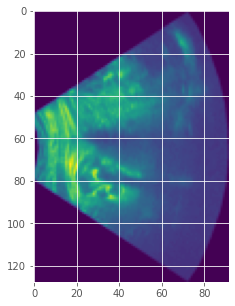

In [0]:
example_frame=f['subject000000_frame00000000']
print(type(example_frame))
plt.imshow(example_frame)
all_frames = [file for file in elements if "frame0" in file]

## 'subjectxxxxxx_labelyyyyyy'
These are the labels they are each 'h5py._hl.dataset.Dataset' files

In [0]:
example_label=f['subject000000_label00000001']
print(type(example_label))
all_labels = [file.replace('frame', 'label') for file in all_frames]

<class 'h5py._hl.dataset.Dataset'>


In [0]:
def summarise_patients(file):
    all_frames = [file for file in elements if "frame0" in file]
    all_labels = [frame.replace('frame', 'label') for frame in all_frames]
    patients_dict={}
    for s in all_frames:
        patients_dict[s.split('_')[0]]=patients_dict.get(s.split('_')[0], 0) + 1    
    all_patient_list=list(patients_dict.keys())
    all_patient_summary=np.zeros((266,np.array(f['num_classes']).item()))
    #Something here is slow lol sorry. Just wanted it to work rather than be efficient.
    for string in all_labels:
        all_patient_summary[all_patient_list.index(string.split('_')[0]),np.array(f[string])]+=1
    return all_patient_summary

def plot_summary(all_patient_summary,patients):
    patient_summary=all_patient_summary[patients]
    organs = ['Nuclear', 'Hydro', 'Gas', 'Oil']
    #Plot the total number of frames with each organ
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.bar(organs, patient_summary.sum(axis=0),color='blue',alpha = 0.5)
    ax1.set_ylabel('Number')
    ax2.bar(organs, patient_summary.sum(axis=0)/patient_summary.sum(),color='red',alpha = 0.5)
    ax2.grid(False)
    ax2.set_ylabel('Proportion')
    fig.suptitle('Overall number of frames per organ')
    plt.show()
    #Plot the total number of frames with each organ
    plt.hist(patient_summary.sum(axis=1),color='blue')
    plt.title('Histogram of number of scans per patient' + "mean = " + str(all_patient_summary.sum(axis=1).mean()))
    plt.show()
    #Plot histogram of number of each organ for each patient
    fig,a =  plt.subplots(1,4,sharex=True, sharey=True)
    a[0].hist(patient_summary[:,0],color='red')
    a[0].set_title(organs[0] + ": mean = " + str(round(patient_summary[:,0].mean(),2)))
    a[1].hist(patient_summary[:,1],color='green')
    a[1].set_title(organs[1] + ": mean = " + str(round(patient_summary[:,1].mean(),2)))
    a[2].hist(patient_summary[:,2],color='blue')
    a[2].set_title(organs[2] + ": mean = " + str(round(patient_summary[:,2].mean(),2)))
    a[3].hist(patient_summary[:,3],color='yellow')
    a[3].set_title(organs[3] + ": mean = " + str(round(patient_summary[:,3].mean(),2)))
    fig.suptitle('Distribution of classes by patient')

# Summarising all the data
## Overall distribution of classes
First look at the number of frames containing each organ. Class 1 has the most frame examples whereas class 3 has around a quarter of the number of frames.

## Number of scans per patient
Most patients have 50 scans but there is a long tail

## Distribution of classes by patient
Worth nothing that although there are a lot of (class 4), there are also the most patients with zero frames containing (class 4). Once we've chosen some patients randomly we'll check this distribution isn't miles out of whack.

In [0]:
all_patient_summary = summarise_patients(f)

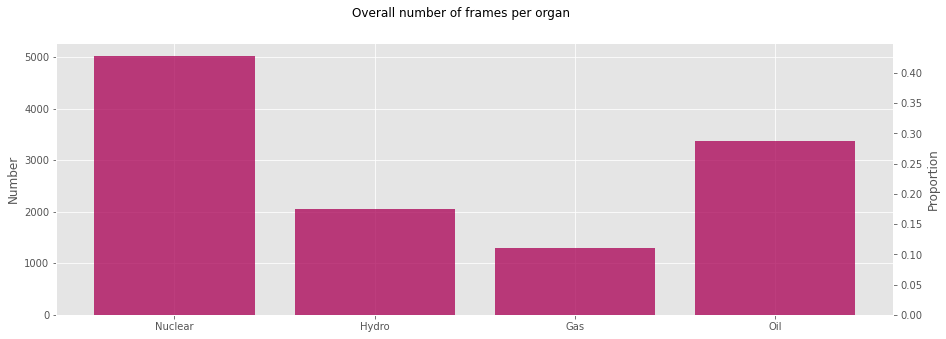

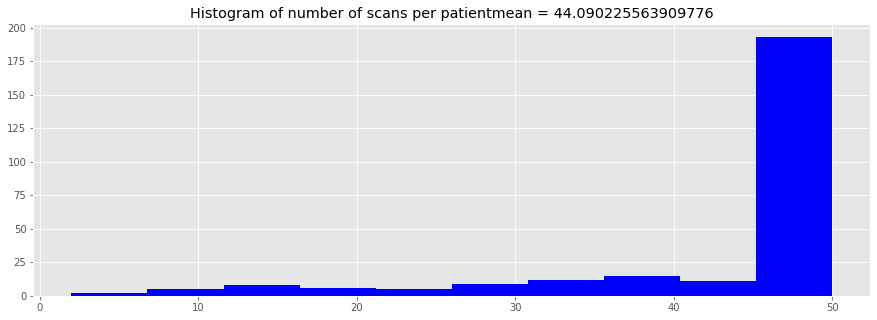

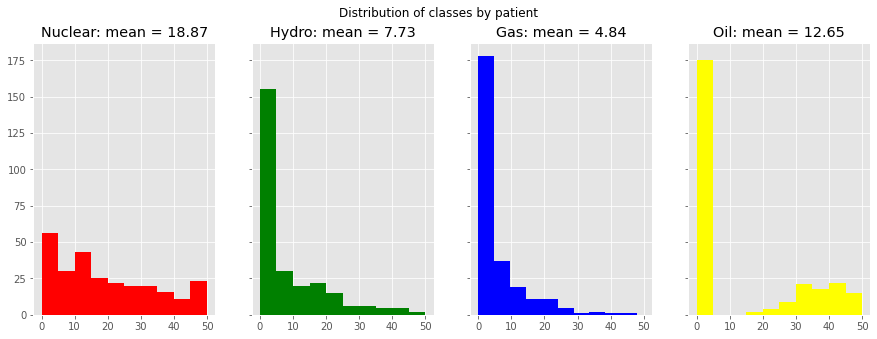

In [0]:
plot_summary(all_patient_summary, list(np.arange(266)))

# Set up a 70:20:10 train-val-test split with random seed 42

In [0]:
num_subjects = tf.keras.utils.HDF5Matrix(filename, '/num_subjects').data[0][0]
np.random.seed(42)
all_indices=np.arange(num_subjects)
np.random.shuffle(all_indices)
train_indices,val_indices,test_indices=np.split(all_indices,[int(round(0.7*num_subjects,0)),int(round(0.9*num_subjects,0))])


Instructions for updating:
Training with HDF5Matrix is not optimized for performance. Instead, we recommend using https://github.com/tensorflow/io to load your HDF5 data into a tf.data Dataset and passing that dataset to Keras.


# A look at our training data

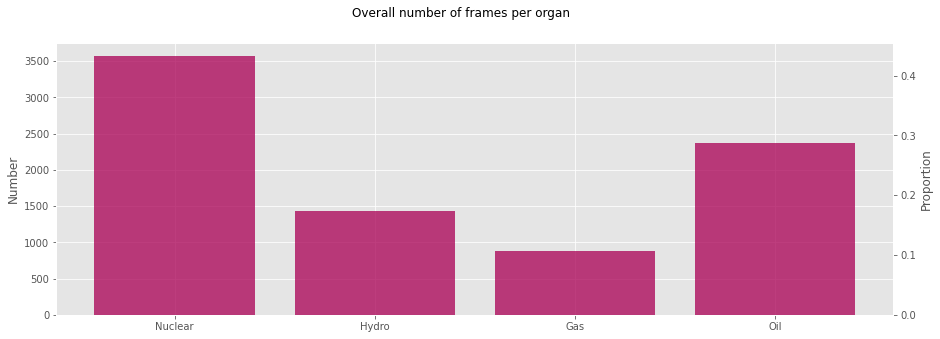

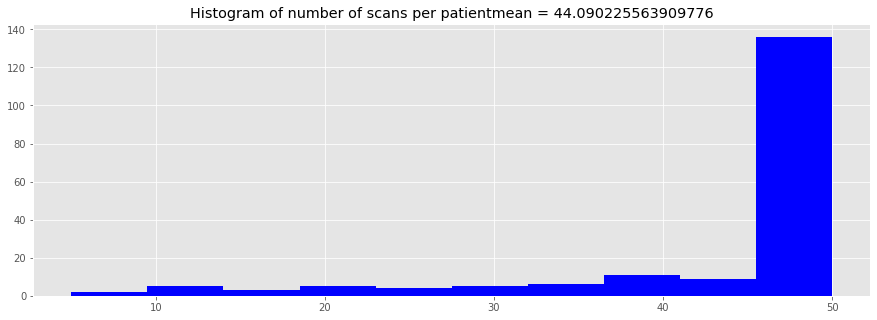

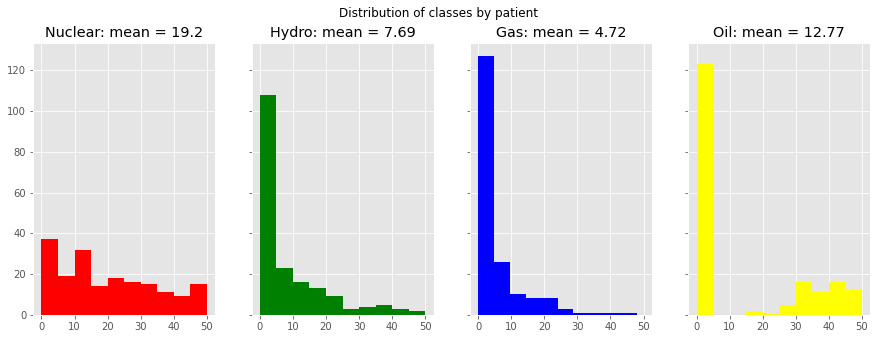

In [0]:
plot_summary(all_patient_summary,train_indices)

# A look at our validation data

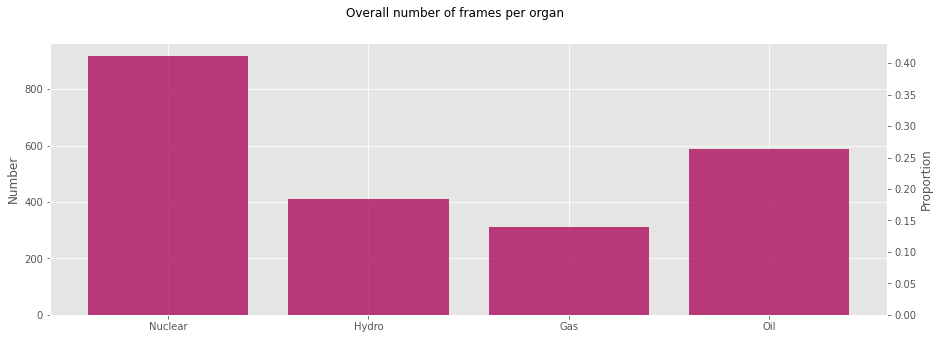

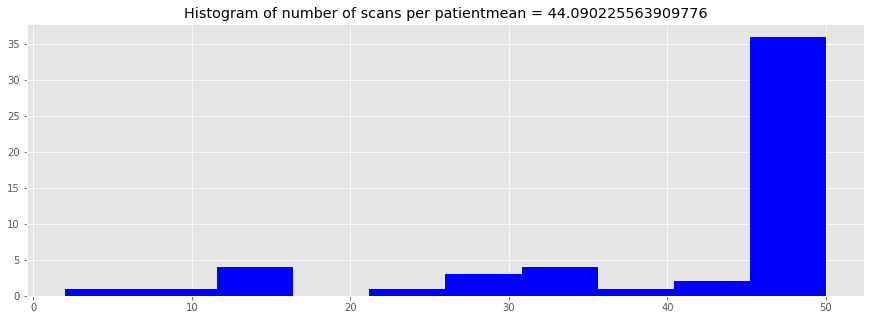

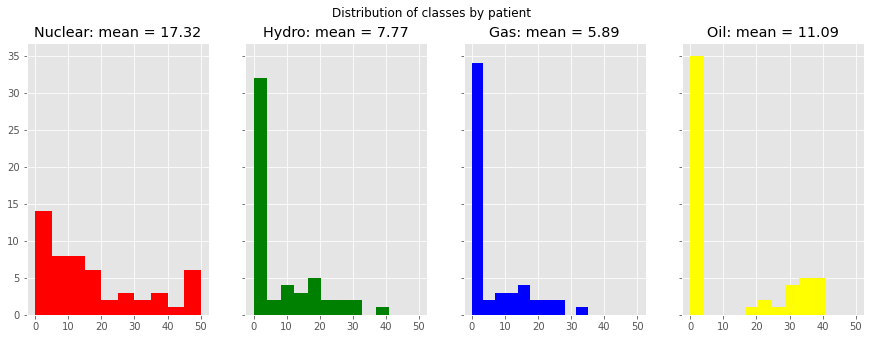

In [0]:
plot_summary(all_patient_summary,val_indices)

# A look at our test data

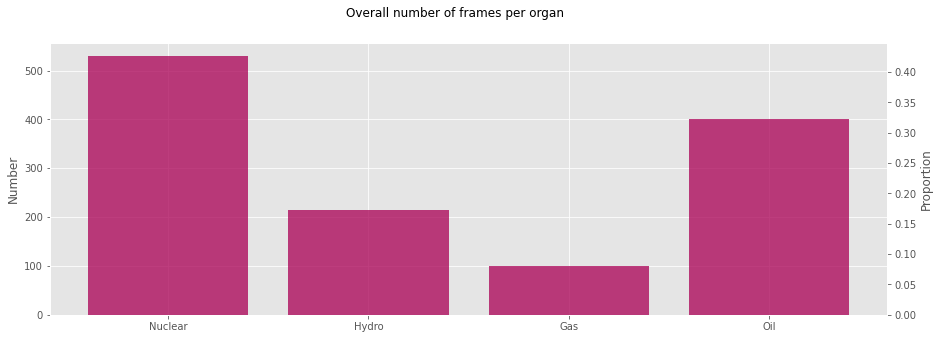

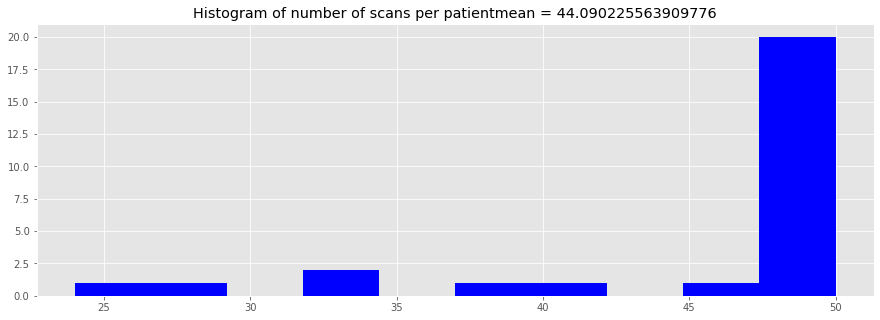

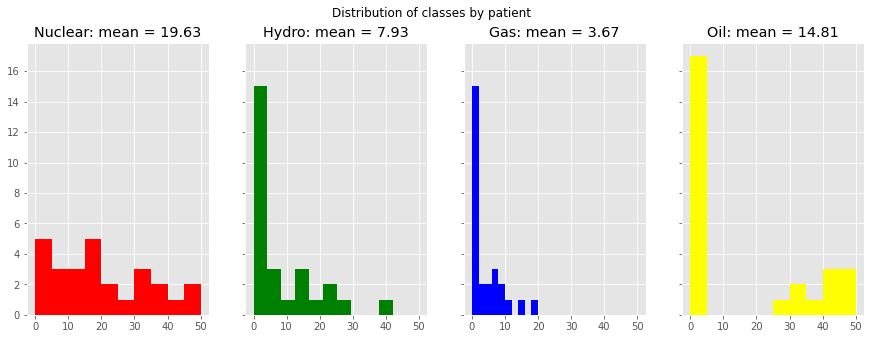

In [0]:
plot_summary(all_patient_summary,test_indices)

# Nice thing is we can use Yipeng's generator structure to load data as and when needed.

In [0]:
filename = './data/ultrasound_50frames.h5'
frame_size = tf.keras.utils.HDF5Matrix(filename, '/frame_size')
frame_size = [frame_size[0][0],frame_size[1][0]]
num_classes = tf.keras.utils.HDF5Matrix(filename, '/num_classes')[0][0]
num_subjects = tf.keras.utils.HDF5Matrix(filename, '/num_subjects')[0][0]
subject_indices = range(num_subjects)

def data_generator(subject_indices,class_labels=[0,1,2,3]):
    for iSbj in subject_indices:
        dataset = '/subject%06d_num_frames' % iSbj
        num_frames = tf.keras.utils.HDF5Matrix(filename, dataset)[0][0]
        for idx_frame in range(num_frames):
            dataset = '/subject%06d_label%08d' % (iSbj, idx_frame)
            label = tf.keras.utils.HDF5Matrix(filename, dataset)[0][0]
            #If all classes leave as original label else change to 1
            if label in class_labels:
                if len(class_labels)==1:
                  label = 1
            else:
                label = 0
            dataset = '/subject%06d_frame%08d' % (iSbj, idx_frame)
            frame = tf.transpose(tf.keras.utils.HDF5Matrix(filename, dataset)) / 255
            yield (tf.expand_dims(frame, axis=2), label)

multi_class_dataset_train = tf.data.Dataset.from_generator(generator = data_generator, 
                                         output_types = (tf.float32, tf.int32),
                                         output_shapes = (frame_size+[1], ()),args=(train_indices,[0,1,2,3]))

class_0_dataset_train = tf.data.Dataset.from_generator(generator = data_generator, 
                                         output_types = (tf.float32, tf.int32),
                                         output_shapes = (frame_size+[1], ()),args=(train_indices,[0]))

class_1_dataset_train = tf.data.Dataset.from_generator(generator = data_generator, 
                                         output_types = (tf.float32, tf.int32),
                                         output_shapes = (frame_size+[1], ()),args=(train_indices,[1]))

class_2_dataset_train = tf.data.Dataset.from_generator(generator = data_generator, 
                                         output_types = (tf.float32, tf.int32),
                                         output_shapes = (frame_size+[1], ()),args=(train_indices,[2]))

class_3_dataset_train = tf.data.Dataset.from_generator(generator = data_generator, 
                                         output_types = (tf.float32, tf.int32),
                                         output_shapes = (frame_size+[1], ()),args=(train_indices,[3]))

multi_class_dataset_val = tf.data.Dataset.from_generator(generator = data_generator, 
                                         output_types = (tf.float32, tf.int32),
                                         output_shapes = (frame_size+[1], ()),args=(val_indices,[0,1,2,3]))

class_0_dataset_val = tf.data.Dataset.from_generator(generator = data_generator, 
                                         output_types = (tf.float32, tf.int32),
                                         output_shapes = (frame_size+[1], ()),args=(val_indices,[0]))

class_1_dataset_val = tf.data.Dataset.from_generator(generator = data_generator, 
                                         output_types = (tf.float32, tf.int32),
                                         output_shapes = (frame_size+[1], ()),args=(val_indices,[1]))

class_2_dataset_val = tf.data.Dataset.from_generator(generator = data_generator, 
                                         output_types = (tf.float32, tf.int32),
                                         output_shapes = (frame_size+[1], ()),args=(val_indices,[2]))

class_3_dataset_val = tf.data.Dataset.from_generator(generator = data_generator, 
                                         output_types = (tf.float32, tf.int32),
                                         output_shapes = (frame_size+[1], ()),args=(val_indices,[3]))

multi_class_dataset_test = tf.data.Dataset.from_generator(generator = data_generator, 
                                         output_types = (tf.float32, tf.int32),
                                         output_shapes = (frame_size+[1], ()),args=(test_indices,[0,1,2,3]))

class_0_dataset_test = tf.data.Dataset.from_generator(generator = data_generator, 
                                         output_types = (tf.float32, tf.int32),
                                         output_shapes = (frame_size+[1], ()),args=(test_indices,[0]))

class_1_dataset_test = tf.data.Dataset.from_generator(generator = data_generator, 
                                         output_types = (tf.float32, tf.int32),
                                         output_shapes = (frame_size+[1], ()),args=(test_indices,[1]))

class_2_dataset_test = tf.data.Dataset.from_generator(generator = data_generator, 
                                         output_types = (tf.float32, tf.int32),
                                         output_shapes = (frame_size+[1], ()),args=(test_indices,[2]))

class_3_dataset_test = tf.data.Dataset.from_generator(generator = data_generator, 
                                         output_types = (tf.float32, tf.int32),
                                         output_shapes = (frame_size+[1], ()),args=(test_indices,[3]))

# Create a model
Argument 'multi' for multihead

In [0]:
import random
def create_model(head='multi'):
  filename = './data/ultrasound_50frames.h5'

  frame_size = tf.keras.utils.HDF5Matrix(filename, '/frame_size')
  frame_size = [frame_size[0][0],frame_size[1][0]]
  num_classes = tf.keras.utils.HDF5Matrix(filename, '/num_classes')[0][0]

  # place holder for input image frames
  features_input = tf.keras.Input(shape=frame_size+[1])
  features = tf.keras.layers.Conv2D(32, 7, activation='relu')(features_input)

  features = tf.keras.layers.MaxPool2D(3)(features)
  features_block_1 = tf.keras.layers.Conv2D(64, 3, activation='relu')(features)
  features = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(features_block_1)
  features = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(features)
  features_block_2 = features + features_block_1
  features = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(features_block_2)
  features = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(features)
  features = features + features_block_2

  features = tf.keras.layers.MaxPool2D(3)(features)
  features_block_3 = tf.keras.layers.Conv2D(128, 3, activation='relu')(features)
  features = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(features_block_3)
  features = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(features)
  features_block_4 = features + features_block_3
  features = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(features_block_4)
  features = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(features)
  features_block_5 = features + features_block_4
  features = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(features_block_5)
  features = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(features)
  features_block_6 = features + features_block_5
  features = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(features_block_6)
  features = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(features)
  features = features + features_block_6

  features = tf.keras.layers.Conv2D(128, 3, activation='relu')(features)
  features = tf.keras.layers.GlobalAveragePooling2D()(features)
  features = tf.keras.layers.Dense(units=256, activation='relu')(features)
  features = tf.keras.layers.Dropout(0.5)(features)
  if head=='multi':
    output = tf.keras.layers.Dense(units=num_classes, activation='softmax')(features)
  else:
    output = tf.keras.layers.Dense(units=1, activation='sigmoid')(features)
  # now the model
  return tf.keras.Model(inputs=features_input, outputs=output)
  

# Yipeng's train code:

In [0]:
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


In [0]:
def train_model(dataset_batch,dataset_batch_val,model_type='multi'):
  #'multi' for multi head, anything else for single head. Defaults to multi. 
  model = create_model(model_type)
  if model_type=='multi':
    loss='sparse_categorical_crossentropy'
  if model_type=='single':
    loss='binary_cross_entropy'
  model.compile(optimizer='adam',
                loss=loss,
                metrics=['accuracy'])
  model.summary()
  logdir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
  earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto',baseline=None, restore_best_weights=False)
  model.fit(dataset_batch,
            validation_data=dataset_batch_val,
            epochs=1000, 
            callbacks=[tensorboard_callback,earlystop_callback])

  return model
dataset=class_2_dataset_train
dataset_batch = dataset.shuffle(1024).batch(32)
dataset_val=class_2_dataset_val
dataset_batch_val = dataset.shuffle(1024).batch(32)

model = train_model(dataset_batch,dataset_batch_val)


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 92, 128, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 86, 122, 32)  1600        input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 28, 40, 32)   0           conv2d_32[0][0]                  
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 26, 38, 64)   18496       max_pooling2d_4[0][0]            
____________________________________________________________________________________________

# Some code for testing (only use for out of sample results!)

In [0]:
ds=class_2_dataset_test
ds = ds.cache()
dataset_batch = ds.shuffle(buffer_size=1024).batch(32)
model.evaluate(dataset_batch)

     39/Unknown - 18s 470ms/step - loss: 0.2325 - accuracy: 0.9244

[0.23253278114283696, 0.9243765]

# Multiclass in case Ariane doesn't notice my mistake

In [0]:
dataset=multi_class_dataset_train
dataset_batch = dataset.shuffle(1024).batch(32)
dataset_val=multi_class_dataset_val
dataset_batch_val = dataset.shuffle(1024).batch(32)

model = train_model(dataset_batch,dataset_batch_val)

In [0]:
ds=multi_class_dataset_test
ds = ds.cache()
dataset_batch = ds.shuffle(buffer_size=1024).batch(32)
model.evaluate(dataset_batch)